In [39]:
import sys
sys.path.append('..')

import transformers
import torch
import tqdm

import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from utility.minio import cmd
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from training_worker.ab_ranking.model.ab_ranking_elm_v1 import ABRankingELMModel
from training_worker.ab_ranking.model.ab_ranking_linear import ABRankingModel
from transformers import CLIPTokenizer, CLIPTextModel
from sklearn.metrics import confusion_matrix

transformers.logging.set_verbosity_error()

## Loading models, CSV dataset

In [2]:
tokenizer = CLIPTokenizer.from_pretrained('../../kcg-ml-n-grams/weights/txt_emb_tokenizer')
model = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14').eval().to('cuda')

def load_models(
    elm_model_weights,
    linear_model_weights
):
    elm_model = ABRankingELMModel(768)
    elm_model.load(elm_model_weights)

    linear_model = ABRankingModel(768)
    linear_model.load(linear_model_weights)

    return elm_model, linear_model

elm_model, linear_model = load_models(
    '../../models/2023-11-15-00-score-elm-v1-embedding-positive.pth',
    '../../models/2023-11-15-00-score-linear-embedding-positive.pth'
)

def embed(prompt):
    with torch.no_grad():
        token_encoding = tokenizer(prompt, return_length=True, return_tensors='pt')
        embedding = model(input_ids=token_encoding['input_ids'].to('cuda')).last_hidden_state[0]

    return embedding

def score_prompt(prompt):
    embedding = embed(prompt)
    embedding = embedding.unsqueeze(0).permute(0, 2, 1)
    score = elm_model.predict_positive_or_negative_only(embedding).item()

    return score

inputs_shape= 768


In [3]:
df = pd.read_csv('../output/20231115_environment_phrase/environment_data.csv')
df['positive_tokens'] = df['positive_prompt'].apply(lambda x: x.split(', '))
df.head()

,job_uuid,creation_time,dataset,file_path,file_hash,positive_prompt,negative_prompt,positive_tokens
0,e9fcd18d-71cd-4320-a2f5-32e02c872cc5,2023-10-04 08:41:30,environmental,environmental/0001/000000_embedding.msgpack,837a665df2e743f67805b74d8e504fd382d82490a8e9a0...,"environmental, pixel art, concept art, side sc...","bad hands, jewelry, extra fingers, (signature:...","[environmental, pixel art, concept art, side s..."
1,cbf2af24-ecc9-4488-8856-78bee4e16a48,2023-10-04 08:41:32,environmental,environmental/0001/000001_embedding.msgpack,cf7af99247760c7b9d8289e4da0e1c12be87e6bc1d0a4c...,"environmental, pixel art, concept art, side sc...","one hand with less than 5 digit, chibi, (nude)...","[environmental, pixel art, concept art, side s..."
2,058c38f7-a127-4c51-915f-b1f30fb6af61,2023-10-04 08:41:34,environmental,environmental/0001/000002_embedding.msgpack,1fdfc57b9ce269ef63c8616cf049d013a65b21d77724a6...,"environmental, pixel art, concept art, side sc...","((close up)), (deformed), worstquality, ((mono...","[environmental, pixel art, concept art, side s..."
3,858a0748-f430-4ad3-880e-68dd78360e59,2023-10-04 08:41:36,environmental,environmental/0001/000003_embedding.msgpack,266cc99b152bcb4e6458b8c96a2ad46ebf90289be8e8e1...,"environmental, pixel art, concept art, side sc...",desaturated washed-out image with ( ( low colo...,"[environmental, pixel art, concept art, side s..."
4,b9e80cab-b47e-4ef0-9f11-291bf55b5b21,2023-10-04 08:41:38,environmental,environmental/0001/000004_embedding.msgpack,3f369864f303f237a6ee828ee323b3b1f7f65ec0d32a2e...,"environmental, pixel art, concept art, side sc...","(worst quality:1.2), normal quality, deepnegat...","[environmental, pixel art, concept art, side s..."


In [4]:
df_phrase = pd.read_csv('../output/20231115_environment_phrase.csv')
df_phrase.head()

,phrase str,token_length,positive count,negative count,probability,log probability
0,seductive,3,25,0,1.662620e-05,-11.004531
1,!,3,33,0,2.194658e-05,-10.726899
2,!!,3,1,0,6.650479e-07,-14.223407
3,!!!simple!!!,5,4,0,2.660192e-06,-12.837112
4,!bodycam footage of satan being arrested in hell,12,1,0,6.650479e-07,-14.223407


### Filter prompts

In [5]:
to_keep = []
phrase_list = df_phrase['phrase str'].tolist()

for idx, row in df.iterrows():
    tokens = row['positive_tokens']
    token_length = tokenizer(row['positive_prompt'], return_length=True)['length']

    # remove prompts with phrases not in the phrase list (phrase list is already filtered)
    # remove prompts where token length is more than 77
    if set(tokens).issubset(phrase_list) and token_length <= 77:
        to_keep.append(idx)

df_filtered = df.iloc[to_keep]

## Create dataset

In [6]:
# visualize the top prompts

df_filtered['score'] = df_filtered['positive_prompt'].apply(lambda x: score_prompt(x))
df_sort = df_filtered.sort_values('score', ascending=False)
df_sort.head()

/tmp/ipykernel_43312/2950728767.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['score'] = df_filtered['positive_prompt'].apply(lambda x: score_prompt(x))


,job_uuid,creation_time,dataset,file_path,file_hash,positive_prompt,negative_prompt,positive_tokens,score
71550,f9b39fc4-c5ff-4dee-9451-7d1ff093e5af,2023-11-13 20:38:10,environmental,environmental/0075/074198_embedding.msgpack,d436a8da1cb620b3082e0a34cb08f06662a1a86c7e0a74...,"under the sea, cyberpunk, side scrolling conce...","border, text, shadows, defomations, glasses, f...","[under the sea, cyberpunk, side scrolling conc...",3364.260498
54601,18490aad-55c0-49bf-9332-0e5b8884d4b4,2023-11-08 07:33:52,environmental,environmental/0058/057249_embedding.msgpack,9f5734c503cbb95b3be9f3cc50831d468fbd7004e0808e...,"level design, 2D environmental, side scrolling...","{{{masterpiece}}}, pixel art, huge penis, ball...","[level design, 2D environmental, side scrollin...",3255.714355
55315,abef9ca4-db17-4a57-8ccc-4913b0497a6a,2023-11-08 07:37:59,environmental,environmental/0058/057963_embedding.msgpack,5a059e606450fdccc1b30dc00196d438f122b8e004f3ca...,"2d video game concept art, environmental, snes...","parody, oily skin, big breast, purple dress, 1...","[2d video game concept art, environmental, sne...",3195.381348
59474,6bb97535-42f8-4330-a9b4-7127215cacce,2023-11-09 13:12:33,environmental,environmental/0063/062122_embedding.msgpack,de27a69c4261d73f17de1475ccf1d52f40f9fe4e7617d6...,"video game concept art, 2D environmental art s...","watermark, text, camera, shading, foliage and ...","[video game concept art, 2D environmental art ...",3193.355957
55137,58e7dbff-3006-4885-9270-234f6bd95743,2023-11-08 07:36:57,environmental,environmental/0058/057785_embedding.msgpack,2b6625a4dc3c75255a62824e59b455b263e015ce7008d2...,"underground, 2D environmental, 2D side scrolli...","{{{masterpiece}}}, captivating, daylight, star...","[underground, 2D environmental, 2D side scroll...",3163.203125


For each prompt:
1. Loop through every phrase
2. Remove phrase (keep all other phrases) and compute score    

Model will be trained to predict if score goes up or down after phrase removal  
XGBoost model::
- Input: Original prompt embedding + Removed phrase embedding
- Output: Probability of score going up (0 for score going down)

In [7]:
dataset = []
pbar = tqdm.tqdm(df_sort.iterrows(), total=len(df_sort))
for idx, row in pbar:
    tokens = row['positive_tokens']
    prompt_score = row['score']
    prompt_embedding = embed(row['positive_prompt'])
    prompt_embedding = torch.mean(prompt_embedding, dim=0).cpu().numpy()

    # remove phrase
    for to_remove in tokens:
        updated_prompt = [element for element in tokens if element != to_remove]

        to_remove_embedding = torch.mean(embed(to_remove), dim=0).cpu().numpy()
        updated_prompt_embedding = embed(', '.join(updated_prompt))

        updated_prompt_score = score_prompt(', '.join(updated_prompt))

        # concatenate original prompt embedding and emebedding of removed phrase
        # this will be used as model input
        X = np.concatenate([prompt_embedding, to_remove_embedding])

        data = {
            'prompt': row['positive_prompt'],
            'removed': to_remove,
            'X': X,
            'prompt_score': prompt_score,
            'new_score': updated_prompt_score,
            'delta': prompt_score - updated_prompt_score
        }

        dataset.append(data)
    pbar.update(1)

100%|██████████| 9326/9326 [37:30<00:00,  4.14it/s]


Create labels for dataset.  
delta = prompt_score - new_score  
y = 1 if score increased after removal else 0

In [21]:
# create prediction labels
# dataset = pd.DataFrame(dataset)
dataset['y'] = dataset['delta'] < 0
dataset['y'] = dataset['y'].astype(int)
dataset['sigma'] = dataset['new_score'].apply(
    lambda x: (x - dataset['prompt_score'].mean()) / dataset['prompt_score'].std()
)
dataset['delta_z'] = dataset['delta'].apply(lambda x: x / dataset['prompt_score'].std())
dataset.to_csv('../output/20231115_prompt_removal_dataset.csv')
dataset.head()

,prompt,removed,X,prompt_score,new_score,delta,y,sigma,delta_z
0,"under the sea, cyberpunk, side scrolling conce...",under the sea,"[0.5424623, -0.6115431, 0.6516487, -0.43766186...",3364.260498,3086.870605,277.389893,0,2.180243,0.507614
1,"under the sea, cyberpunk, side scrolling conce...",cyberpunk,"[0.5424623, -0.6115431, 0.6516487, -0.43766186...",3364.260498,3259.261230,104.999268,0,2.495712,0.192145
2,"under the sea, cyberpunk, side scrolling conce...",side scrolling concept art,"[0.5424623, -0.6115431, 0.6516487, -0.43766186...",3364.260498,3026.538086,337.722412,0,2.069836,0.618020
3,"under the sea, cyberpunk, side scrolling conce...",full body,"[0.5424623, -0.6115431, 0.6516487, -0.43766186...",3364.260498,3366.242920,-1.982422,1,2.691485,-0.003628
4,"under the sea, cyberpunk, side scrolling conce...",extremely neat,"[0.5424623, -0.6115431, 0.6516487, -0.43766186...",3364.260498,3311.652344,52.608154,0,2.591586,0.096271


In [22]:
# check the stats for delta
dataset.describe()

,prompt_score,new_score,delta,y,sigma,delta_z
count,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000
mean,1895.458739,1850.080396,45.378343,0.299417,-0.083041,0.083041
std,546.458320,551.914131,119.029229,0.458004,1.009984,0.217819
min,39.235107,-307.224304,-929.245361,0.000000,-4.030834,-1.700487
25%,1449.161865,1402.984070,-8.261902,0.000000,-0.901212,-0.015119
50%,1933.807739,1878.767151,27.633728,0.000000,-0.030545,0.050569
75%,2330.526123,2290.816345,75.864563,1.000000,0.723491,0.138830
max,3364.260498,3550.166260,2313.831116,1.000000,3.028058,4.234232


In [23]:
dataset[dataset['y'] == 1].describe()

,prompt_score,new_score,delta,y,sigma,delta_z
count,47172.000000,47172.000000,47172.000000,47172.0,47172.000000,47172.000000
mean,1892.394577,1945.444218,-53.049641,1.0,0.091472,-0.097079
std,544.550887,541.919980,61.727417,0.0,0.991695,0.112959
min,262.523285,323.482666,-929.245361,1.0,-2.876662,-1.700487
25%,1447.476318,1502.618134,-69.618530,1.0,-0.718885,-0.127400
50%,1941.366089,1990.181824,-32.464050,1.0,0.173340,-0.059408
75%,2324.021973,2376.848938,-13.189056,1.0,0.880928,-0.024136
max,3364.260498,3550.166260,-0.000732,1.0,3.028058,-0.000001


Split dataset for training

In [28]:
X = np.stack(dataset['X'].values)
y = dataset['sigma']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

## Grid search

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
xgb_model = xgb.XGBRegressor()

param_grid = {
    'max_depth': [3, 5, 7],  # Maximum depth of a tree
    'learning_rate': [0.05, 0.1, 0.2],  # Learning rate
    'n_estimators': [100, 200],  # Number of trees (boosting rounds)
    'subsample': [0.8, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.7, 1.0],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1],  # Minimum loss reduction required to make a further partition on a leaf node
    'min_child_weight': [1, 5]  # Minimum sum of instance weight (hessian) needed in a child
}

grid_search = GridSearchCV(
    xgb_model,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=kfold,
    n_jobs=5,
    verbose=3,
)

grid_result = grid_search.fit(X_train, y_train)

best_params = grid_result.best_params_
best_score = grid_result.best_score_

print(f'Best params:\n{best_params}\n\n')
print(f'Best score:\n{best_score}')

In [35]:
params = {
    # 'objective': 'binary:logistic',
    'objective': 'reg:squarederror',
    # 'eval_metric': ['logloss'],
    'max_depth': 7,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
    'eta': 0.05,
    'gamma': 0.01
}

evals = [(train_data, 'train'), (test_data, 'eval')]

# Train the XGBoost model
evals_result = {}
model = xgb.train(
    params,
    train_data,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    evals_result=evals_result
)

# compute prediction
train_preds = model.predict(train_data)
val_preds = model.predict(test_data)

# compute root mean square error
train_rmse = evals_result['train']['rmse']
val_rmse = evals_result['eval']['rmse']

# compute residuals
train_residuals = y_train - train_preds
val_residuals = y_test - val_preds

[0]	train-rmse:0.93747	eval-rmse:0.92936
[1]	train-rmse:0.87172	eval-rmse:0.86449
[2]	train-rmse:0.81231	eval-rmse:0.80600
[3]	train-rmse:0.75913	eval-rmse:0.75372
[4]	train-rmse:0.71080	eval-rmse:0.70629
[5]	train-rmse:0.66844	eval-rmse:0.66494
[6]	train-rmse:0.62995	eval-rmse:0.62739
[7]	train-rmse:0.59523	eval-rmse:0.59354
[8]	train-rmse:0.56406	eval-rmse:0.56319
[9]	train-rmse:0.53592	eval-rmse:0.53566
[10]	train-rmse:0.51086	eval-rmse:0.51147
[11]	train-rmse:0.48802	eval-rmse:0.48929
[12]	train-rmse:0.46727	eval-rmse:0.46886
[13]	train-rmse:0.44835	eval-rmse:0.45047
[14]	train-rmse:0.43120	eval-rmse:0.43380
[15]	train-rmse:0.41594	eval-rmse:0.41918
[16]	train-rmse:0.40179	eval-rmse:0.40537
[17]	train-rmse:0.38888	eval-rmse:0.39294
[18]	train-rmse:0.37692	eval-rmse:0.38148
[19]	train-rmse:0.36575	eval-rmse:0.37086
[20]	train-rmse:0.35574	eval-rmse:0.36154
[21]	train-rmse:0.34639	eval-rmse:0.35281
[22]	train-rmse:0.33762	eval-rmse:0.34445
[23]	train-rmse:0.32950	eval-rmse:0.33675
[2

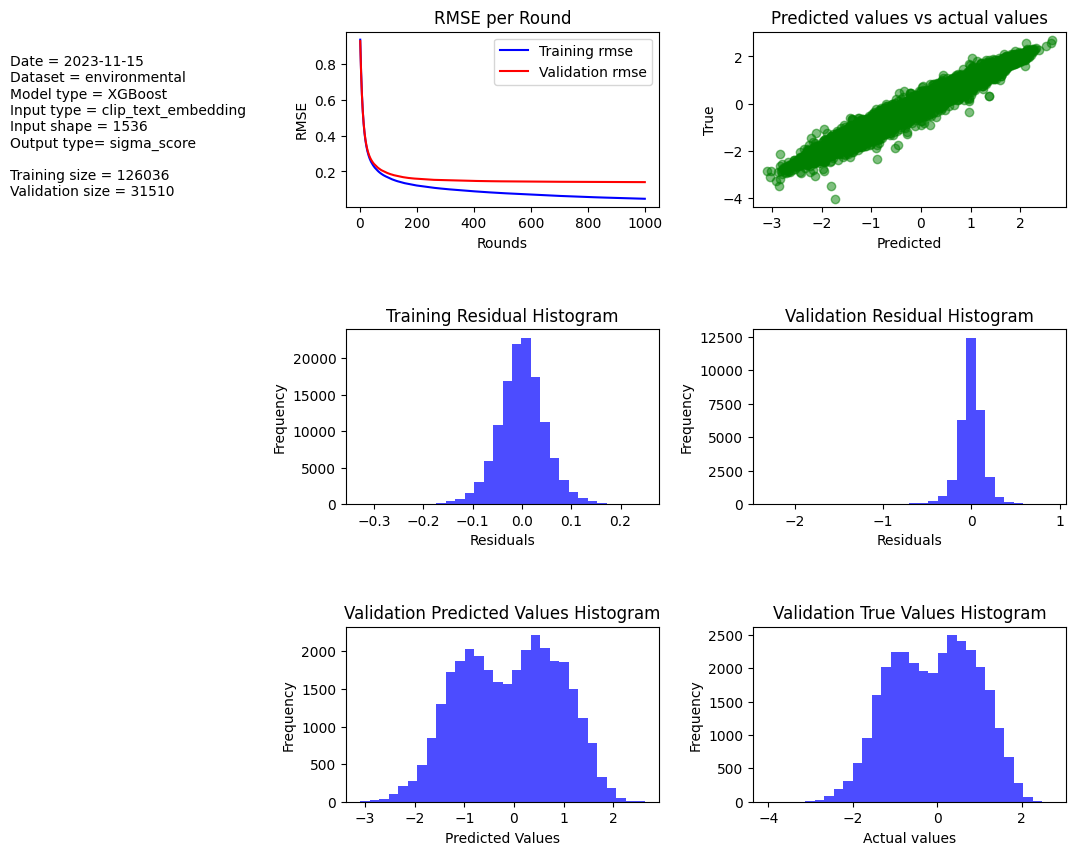

In [40]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
        
#info text about the model
plt.figtext(
    0.02, 0.7, "Date = {}\n"
    "Dataset = {}\n"
    "Model type = {}\n"
    "Input type = {}\n"
    "Input shape = {}\n"
    "Output type= {}\n\n"
    ""
    "Training size = {}\n"
    "Validation size = {}\n".format(
        datetime.now().strftime("%Y-%m-%d"),
        'environmental',
        'XGBoost',
        'clip_text_embedding',
        '1536',
        'sigma_score',
        len(X_train),
        len(X_test),
    )
)

# Plot validation and training Rmse vs. Rounds
axs[0][0].plot(range(1, len(train_rmse) + 1), train_rmse,'b', label='Training rmse')
axs[0][0].plot(range(1, len(val_rmse) + 1), val_rmse,'r', label='Validation rmse')
axs[0][0].set_title('RMSE per Round')
axs[0][0].set_ylabel('RMSE')
axs[0][0].set_xlabel('Rounds')
axs[0][0].legend(['Training rmse', 'Validation rmse'])

# Scatter Plot of actual values vs predicted values
axs[0][1].scatter(val_preds, y_test, color='green', alpha=0.5)
axs[0][1].set_title('Predicted values vs actual values')
axs[0][1].set_ylabel('True')
axs[0][1].set_xlabel('Predicted')

# plot histogram of training residuals
axs[1][0].hist(train_residuals, bins=30, color='blue', alpha=0.7)
axs[1][0].set_xlabel('Residuals')
axs[1][0].set_ylabel('Frequency')
axs[1][0].set_title('Training Residual Histogram')

# plot histogram of validation residuals
axs[1][1].hist(val_residuals, bins=30, color='blue', alpha=0.7)
axs[1][1].set_xlabel('Residuals')
axs[1][1].set_ylabel('Frequency')
axs[1][1].set_title('Validation Residual Histogram')

# plot histogram of predicted values
axs[2][0].hist(val_preds, bins=30, color='blue', alpha=0.7)
axs[2][0].set_xlabel('Predicted Values')
axs[2][0].set_ylabel('Frequency')
axs[2][0].set_title('Validation Predicted Values Histogram')

# plot histogram of true values
axs[2][1].hist(y_test, bins=30, color='blue', alpha=0.7)
axs[2][1].set_xlabel('Actual values')
axs[2][1].set_ylabel('Frequency')
axs[2][1].set_title('Validation True Values Histogram')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.7, wspace=0.3, left=0.3)
plt.show()

In [41]:
model.save_model('../output/prompt_mutator_removal_model/20231115_2229_prompt_removal.json')